In [5]:
!pip install langchain-openai python-dotenv openai azure-core azure-search-documents transformers numpy scikit-learn matplotlib seaborn tiktoken


Name: langchain-openai
Version: 0.2.12
Summary: An integration package connecting OpenAI and LangChain
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: langchain-core, openai, tiktoken
Required-by: 
---
Name: python-dotenv
Version: 1.0.1
Summary: Read key-value pairs from a .env file and set them as environment variables
Home-page: https://github.com/theskumar/python-dotenv
Author: Saurabh Kumar
Author-email: me+github@saurabh-kumar.com
License: BSD-3-Clause
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: 
Required-by: pydantic-settings
---
Name: openai
Version: 1.58.1
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /Library/Frameworks/Python.framework/Versions/3.12/li

Some weights of the model checkpoint at mrm8488/bert-multi-cased-finetuned-xquadv1 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Archivo .env encontrado en: /Users/luisalbertocerelli/Desktop/00-Todo/14_Hackaton_Real/00_MAIN_DE_MAIN/03_Modelo_Alucinacion_y_matriz_confusion/.env


Device set to use mps:0


Escribe tus preguntas para la IA. Escribe 'salir' para terminar.
Consultando Azure OpenAI en el endpoint: https://lac-innovation-hallucination.openai.azure.com/ con el modelo: gpt-4
Respuesta generada por ChatGPT: Sí, maximiza exposición solar, reduce sombras, aumenta eficiencia energética.
Respuesta del modelo:
Sí, maximiza exposición solar, reduce sombras, aumenta eficiencia energética.
Evaluando la respuesta con documentos en Azure Search...
Consultando Azure Search con query: 'dime en 10 palabras si es bueno colocar los paneles solares en altura' en el índice: 'documentos-huella'
Documento encontrado: ID=Tabla_CNAE_2022_xlsx, Contenido: 

Numero de empresas por actividad 
GGH por actividad
Media por empresa




Huella del carbono
reduc...
Documento encontrado: ID=Estudio_Empresas_CNAE_2022_xlsx, Contenido: 

Numero de empresas por actividad 
GGH por actividad
Media por empresa




Huella del carbono
reduc...
Documento encontrado: ID=Tecnologia_IA_docx, Contenido: TECNOLOGÍAS PARA R

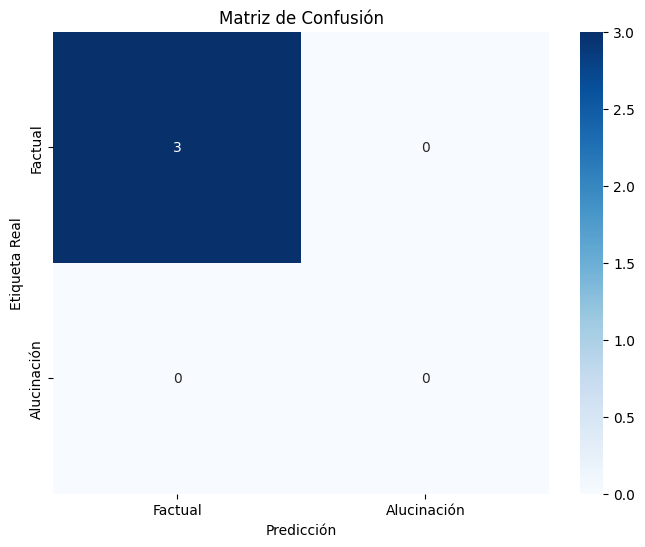

              precision    recall  f1-score   support

     Factual       1.00      1.00      1.00         3
 Alucinación       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         3
   macro avg       0.50      0.50      0.50         3
weighted avg       1.00      1.00      1.00         3



In [ ]:
# Importaciones necesarias
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv, find_dotenv
import os
import openai
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.core.pipeline.policies import RetryPolicy
from transformers import pipeline
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken

# Cargar archivo .env
dotenv_path = find_dotenv()
if dotenv_path:
    print(f"Archivo .env encontrado en: {dotenv_path}")
    load_dotenv(dotenv_path)
else:
    print("Archivo .env no encontrado. Asegúrate de que exista y esté en la ruta correcta.")

# Variables necesarias para Azure AI Search
AZURE_SEARCH_ENDPOINT = os.getenv("SEARCH_SERVICE_ENDPOINT", "").strip()
AZURE_SEARCH_KEY = os.getenv("SEARCH_API_KEY", "").strip()
INDEX_NAME = os.getenv("INDEX_NAME", "").strip()

# Variables necesarias para OpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "").strip()
MODEL_NAME = os.getenv("MODEL_NAME", "text-embedding-ada-002").strip()

# Configurar cliente OpenAI
openai.api_key = OPENAI_API_KEY

# Configuración para Azure OpenAI
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT", "").strip()
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY", "").strip()
ENGINE_NAME = os.getenv("ENGINE_NAME", MODEL_NAME)

if AZURE_OPENAI_ENDPOINT and AZURE_OPENAI_KEY:
    openai.api_type = "azure"
    openai.api_base = AZURE_OPENAI_ENDPOINT
    openai.api_version = "2023-03-15-preview"
    openai.api_key = AZURE_OPENAI_KEY

# Cliente de Azure Cognitive Search
search_client = SearchClient(
    endpoint=AZURE_SEARCH_ENDPOINT,
    index_name=INDEX_NAME,
    credential=AzureKeyCredential(AZURE_SEARCH_KEY)
)

# Cargar modelo para factualidad en español
factual_pipeline = pipeline(
    "question-answering",
    model="mrm8488/bert-multi-cased-finetuned-xquadv1",
    tokenizer="mrm8488/bert-multi-cased-finetuned-xquadv1",
    framework="pt"
)

# Función para interactuar con Azure OpenAI (ChatGPT)
def chat_with_azure_gpt(pregunta):
    """Genera una respuesta utilizando Azure OpenAI (ChatGPT)."""
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    azure_api_key = os.getenv("AZURE_OPENAI_KEY")
    azure_deployment = os.getenv("MODEL_NAME_4")  # Modelo GPT-4 configurado
    azure_api_version = os.getenv("AZURE_API_VERSION")

    # Configurar el modelo de ChatGPT
    chat = AzureChatOpenAI(
        azure_deployment=azure_deployment,
        azure_endpoint=azure_endpoint,
        api_key=azure_api_key,
        api_version=azure_api_version,
        temperature=0,
        max_tokens=1000,
        timeout=None,
        max_retries=2,
    )

    # Generar la respuesta desde ChatGPT
    try:
        print(f"Consultando Azure OpenAI en el endpoint: {azure_endpoint} con el modelo: {azure_deployment}")
        response = chat.invoke(pregunta)
        print(f"Respuesta generada por ChatGPT: {response.content}")
        return response.content  # Respuesta generada por ChatGPT
    except Exception as e:
        print(f"Error al generar la respuesta con Azure OpenAI: {e}")
        return None


# Funciones de procesamiento de texto y embeddings
def contar_tokens(texto, modelo="text-embedding-ada-002"):
    """Cuenta la cantidad de tokens en un texto usando el modelo especificado."""
    tokenizador = tiktoken.encoding_for_model(modelo)
    return len(tokenizador.encode(texto))

def dividir_texto_en_fragmentos(texto, max_tokens=8192):
    """Divide un texto en fragmentos que no excedan el límite de tokens del modelo."""
    tokenizador = tiktoken.encoding_for_model("text-embedding-ada-002")
    tokens = tokenizador.encode(texto)
    for i in range(0, len(tokens), max_tokens):
        yield tokenizador.decode(tokens[i:i + max_tokens])

def validar_embeddings(embedding):
    """Valida que el embedding no contenga NaN o valores inválidos."""
    if embedding is None or not np.isfinite(embedding).all():
        return False
    return True

def obtener_embeddings_batch(textos):
    """Obtiene embeddings para un lote de textos en una sola solicitud, con validación."""
    embeddings_cache = []
    for texto in textos:
        if not texto or not texto.strip():
            print(f"Advertencia: Texto vacío o no válido detectado. Texto: '{texto}'")
            embeddings_cache.append(None)
            continue

        fragmentos = list(dividir_texto_en_fragmentos(texto, max_tokens=8192))
        embedding_total = []

        for fragmento in fragmentos:
            try:
                response = openai.Embedding.create(
                    input=fragmento,
                    engine=ENGINE_NAME
                )
                embedding_fragmento = response['data'][0]['embedding']

                if not validar_embeddings(embedding_fragmento):
                    embeddings_cache.append(None)
                    break

                embedding_total.append(embedding_fragmento)
            except Exception as e:
                embeddings_cache.append(None)
                break

        if embedding_total:
            embeddings_cache.append(np.mean(embedding_total, axis=0))
        else:
            embeddings_cache.append(None)

    return embeddings_cache

def buscar_en_azure(query, index_name="documentos-huella"):
    """Busca documentos en un índice de Azure Search y extrae texto relevante."""
    try:
        # Recuperar las credenciales desde las variables de entorno
        search_service_endpoint = os.getenv("SEARCH_SERVICE_ENDPOINT")
        search_api_key = os.getenv("SEARCH_API_KEY")

        # Verificar que las credenciales estén disponibles
        if not search_service_endpoint or not search_api_key:
            raise ValueError("Las credenciales de Azure Search no están definidas correctamente en el entorno.")

        # Configurar el cliente con políticas de reintento
        retry_policy = RetryPolicy(total_retries=3)
        search_client = SearchClient(
            endpoint=search_service_endpoint,
            index_name=index_name,
            credential=AzureKeyCredential(search_api_key),
            retry_policy=retry_policy
        )

        # Realizar la consulta en el índice
        print(f"Consultando Azure Search con query: '{query}' en el índice: '{index_name}'")
        resultados = search_client.search(query, top=100)

        # Procesar resultados
        documentos = []
        for r in resultados:
            content = r.get("content", "") or r.get("text", "") or r.get("description", "")
            if content:
                print(f"Documento encontrado: ID={r.get('id', 'unknown')}, Contenido: {content[:100]}...")
                documentos.append({
                    "id": r.get("id", "unknown"),
                    "content": content,  # Ajusta según el campo que contiene texto
                    "source": r.get("@search.documentkey", "unknown_source")
                })

        if not documentos:
            print("No se encontraron documentos relevantes para la consulta.")
        else:
            print(f"Total de documentos encontrados: {len(documentos)}")

        return documentos

    except Exception as e:
        print(f"Error al buscar en el índice {index_name}: {e}")
        return []

# evaluar_respuesta_con_azure AUTOMATIZANDO el 'groundtruth':
def evaluar_respuesta_con_azure(respuesta, pregunta):
    """Evalúa la respuesta generada por ChatGPT con los documentos en Azure Search."""
    # Buscar documentos relevantes en Azure Search
    documentos_referencia = buscar_en_azure(pregunta)

    if not documentos_referencia:
        print("No se encontraron documentos relevantes en Azure Search.")
        return 0, False, 0  # Puntaje bajo, no factual, groundtruth automático = 0

    # Verificar factualidad usando similitud con embeddings
    scores_similitud = []
    for doc in documentos_referencia:
        emb_respuesta = obtener_embeddings_batch([respuesta])[0]
        emb_contexto = obtener_embeddings_batch([doc["content"]])[0]

        if emb_respuesta is None or emb_contexto is None:
            print(f"Error al procesar embeddings para el documento ID={doc['id']}")
            continue

        similarity = cosine_similarity([emb_respuesta], [emb_contexto])[0][0]
        scores_similitud.append(similarity)

    print(f"Puntuaciones de similitud: {scores_similitud}")

    # Calcular puntaje promedio
    puntaje = sum(scores_similitud) / len(scores_similitud) if scores_similitud else 0
    print(f"Puntaje promedio: {puntaje:.2f}")

    # Definir un umbral para factualidad
    umbral_factual = 0.6
    es_factual = puntaje >= umbral_factual

    # Determinar groundtruth automático
    groundtruth = 1 if puntaje >= umbral_factual else 0

    return puntaje, es_factual, groundtruth

# evaluar_respuesta_con_azure con el 'groundtruth' MANUAL:
# def evaluar_respuesta_con_azure(respuesta, pregunta):
#     """Evalúa la respuesta generada por ChatGPT con los documentos en Azure Search."""
#     # Buscar documentos relevantes en Azure Search
#     documentos_referencia = buscar_en_azure(pregunta)

#     if not documentos_referencia:
#         print("No se encontraron documentos relevantes en Azure Search.")
#         return 0, False  # Puntaje bajo y no factual

#     # Verificar factualidad usando similitud con embeddings
#     scores_similitud = []
#     for doc in documentos_referencia:
#         emb_respuesta = obtener_embeddings_batch([respuesta])[0]
#         emb_contexto = obtener_embeddings_batch([doc["content"]])[0]

#         if emb_respuesta is None or emb_contexto is None:
#             print(f"Error al procesar embeddings para el documento ID={doc['id']}")
#             continue

#         similarity = cosine_similarity([emb_respuesta], [emb_contexto])[0][0]
#         scores_similitud.append(similarity)

#     print(f"Puntuaciones de similitud: {scores_similitud}")

#     # Calcular puntaje promedio
#     puntaje = sum(scores_similitud) / len(scores_similitud) if scores_similitud else 0
#     print(f"Puntaje promedio: {puntaje:.2f}")

#     # Definir un umbral para factualidad
#     umbral_factual = 0.7  # Ajusta según el caso de uso
#     es_factual = puntaje >= umbral_factual

#     return puntaje, es_factual

# Función para verificar factualidad
def verificar_factualidad_respuesta(respuesta, umbral=0.6):
    """Verifica la factualidad comparando con documentos de Azure."""
    # Llama a buscar_en_azure para obtener documentos relevantes
    documentos_referencia = buscar_en_azure(respuesta)

    if not documentos_referencia:
        print("No se encontraron documentos relevantes para verificar factualidad.")
        return 0, False

    # Compara la respuesta con los documentos usando embeddings
    scores_similitud = []
    for doc in documentos_referencia:
        emb_respuesta = obtener_embeddings_batch([respuesta])[0]
        emb_contexto = obtener_embeddings_batch([doc["content"]])[0]

        if emb_respuesta is None or emb_contexto is None:
            continue

        similarity = cosine_similarity([emb_respuesta], [emb_contexto])[0][0]
        scores_similitud.append(similarity)

    print(f"Puntuaciones de similitud: {scores_similitud}")

    avg_similitud = np.mean(scores_similitud) if scores_similitud else 0
    es_factual = avg_similitud >= umbral
    return avg_similitud, es_factual

# Funciones para evaluar y visualizar resultados
def generar_datos_para_matriz(respuestas_y_groundtruth):
    """Genera predicciones y etiquetas reales."""
    resultados = []
    for entrada in respuestas_y_groundtruth:
        pregunta = entrada["respuesta"]
        groundtruth = entrada["groundtruth"]

        # Obtener la respuesta del modelo
        respuesta_modelo = chat_with_azure_gpt(pregunta)

        # Verificar factualidad comparando con los documentos en Azure
        _, es_factual = verificar_factualidad_respuesta(respuesta_modelo)

        # Determinar predicción: 1 si es factual, 0 si no
        prediccion = 1 if es_factual else 0

        # Mostrar la comparación para depuración
        print(f"Pregunta: {pregunta}")
        print(f"Respuesta del modelo: {respuesta_modelo}")
        print(f"Groundtruth esperado: {groundtruth}, Predicción generada: {prediccion}\n")

        resultados.append({
            "groundtruth": groundtruth,
            "prediction": prediccion
        })

    return resultados

# Función para calcular y mostrar la matriz de confusión
def calcular_matriz_confusion(resultados):
    """Calcula y visualiza la matriz de confusión."""
    groundtruth = [r["groundtruth"] for r in resultados]
    prediction = [r["prediction"] for r in resultados]

    cm = confusion_matrix(groundtruth, prediction, labels=[0, 1])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Factual", "Alucinación"], yticklabels=["Factual", "Alucinación"])
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

    print(classification_report(
    groundtruth,
    prediction,
    target_names=["Factual", "Alucinación"],
    labels=[0, 1],
    zero_division=0
))

# Obtener datos interactivos
def obtener_datos_interactivos():
    """Permite al usuario ingresar preguntas y registrar sus groundtruth después de ver la respuesta."""
    datos = []

    print("Escribe tus preguntas para la IA. Escribe 'salir' para terminar.")
    while True:
        # Pregunta del usuario
        pregunta = input("\nTu pregunta: ")
        if pregunta.lower() == "salir":
            print("Fin de las preguntas.")
            break

        # Generar respuesta del modelo
        respuesta_modelo = chat_with_azure_gpt(pregunta)
        print(f"Respuesta del modelo: {respuesta_modelo}")

        # Ingresar el groundtruth después de ver la respuesta
        while True:
            groundtruth = input("Groundtruth (1 para factual, 0 para alucinación): ")
            if groundtruth in ["0", "1"]:
                break
            print("Groundtruth inválido. Por favor ingresa 0 o 1.")

        datos.append({
            "respuesta": pregunta,
            "groundtruth": int(groundtruth)
        })

    return datos

# Programa principal (con groundtruth automatico)
if __name__ == "__main__":
    # Lista para almacenar preguntas, groundtruth y predicciones
    respuestas_y_groundtruth = []

    print("Escribe tus preguntas para la IA. Escribe 'salir' para terminar.")
    while True:
        # El usuario ingresa una pregunta
        pregunta = input("\nTu pregunta: ")
        if pregunta.lower() == "salir":
            print("Fin del programa.")
            break

        # Paso 1: Generar respuesta con ChatGPT
        respuesta_modelo = chat_with_azure_gpt(pregunta)
        if not respuesta_modelo:
            print("No se pudo generar una respuesta. Inténtalo de nuevo.")
            continue

        print(f"Respuesta del modelo:\n{respuesta_modelo}")

        # Paso 2: Evaluar la respuesta con documentos de Azure
        print("Evaluando la respuesta con documentos en Azure Search...")
        puntaje, es_factual, groundtruth = evaluar_respuesta_con_azure(respuesta_modelo, pregunta)
        print(f"\nPuntaje de similitud con documentos de Azure: {puntaje:.2f}")
        print(f"¿Es factual según el índice? {'Sí' if es_factual else 'No'}")
        print(f"Groundtruth automático: {groundtruth}")

        # Paso 3: Almacenar los datos para la matriz de confusión
        respuestas_y_groundtruth.append({
            "respuesta": pregunta,
            "groundtruth": groundtruth,
            "prediction": 1 if es_factual else 0  # Usar el resultado de la evaluación
        })

    # Generar la matriz de confusión al finalizar
    if respuestas_y_groundtruth:
        print("\nGenerando matriz de confusión...")
        resultados = [{"groundtruth": r["groundtruth"], "prediction": r["prediction"]} for r in respuestas_y_groundtruth]
        calcular_matriz_confusion(resultados)
    else:
        print("No se recopilaron suficientes datos para generar la matriz de confusión.")

# Programa principal(con groundtruth manual)
# if __name__ == "__main__":
#     # Lista para almacenar preguntas, groundtruth y predicciones
#     respuestas_y_groundtruth = []

#     print("Escribe tus preguntas para la IA. Escribe 'salir' para terminar.")
#     while True:
#         # El usuario ingresa una pregunta
#         pregunta = input("\nTu pregunta: ")
#         if pregunta.lower() == "salir":
#             print("Fin del programa.")
#             break

#         # Paso 1: Generar respuesta con ChatGPT
#         respuesta_modelo = chat_with_azure_gpt(pregunta)
#         if not respuesta_modelo:
#             print("No se pudo generar una respuesta. Inténtalo de nuevo.")
#             continue

#         print(f"Respuesta del modelo:\n{respuesta_modelo}")

#         # Paso 2: Evaluar la respuesta con documentos de Azure
#         print("Evaluando la respuesta con documentos en Azure Search...")
#         puntaje, es_factual = evaluar_respuesta_con_azure(respuesta_modelo, pregunta)
#         print(f"\nPuntaje de similitud con documentos de Azure: {puntaje:.2f}")
#         print(f"¿Es factual según el índice? {'Sí' if es_factual else 'No'}")

#         # Paso 3: Solicitar el groundtruth al usuario
#         while True:
#             groundtruth = input("Groundtruth (1 para factual, 0 para alucinación): ")
#             if groundtruth in ["0", "1"]:
#                 groundtruth = int(groundtruth)
#                 break
#             print("Groundtruth inválido. Por favor ingresa 0 o 1.")

#         # Paso 4: Almacenar los datos para la matriz de confusión
#         respuestas_y_groundtruth.append({
#             "respuesta": pregunta,
#             "groundtruth": groundtruth,
#             "prediction": 1 if es_factual else 0  # Usar el resultado de la evaluación
#         })

#     # Generar la matriz de confusión al finalizar
#     if respuestas_y_groundtruth:
#         print("\nGenerando matriz de confusión...")
#         resultados = [{"groundtruth": r["groundtruth"], "prediction": r["prediction"]} for r in respuestas_y_groundtruth]
#         calcular_matriz_confusion(resultados)
#     else:
#         print("No se recopilaron suficientes datos para generar la matriz de confusión.")
